Figure out the coordinates for the WFD region corners for Run 2.

Run 1 specifications:
- WFD corners: [[57.87, -27.25], [58.02, -32.25], [52.11, -32.25], [52.25, -27.25]]
- uDDF corners: [[53.764, -27.533], [53.771, -28.667], [52.479, -28.667], [52.486, -27.533]]

Run 2 specification doc: https://docs.google.com/document/d/18nNVImxGioQ3tcLFMRr67G_jpOzCIOdar9bjqChueQg/edit
- WFD footprint area: 300deg2
- uDDF as in Run 1.
- Relative position of WFD/uDDF same as Run 1 => extend WFD region down and right (increase RA).


#### Method implemented here:
Start with the declination of the corner where uDDF is. Extend ra by ~17 deg; gives second corner. Take the mid-point of the top edge, convert to real degrees, call it x_mid. Redefine x_mid to be zero so that when drop in declination, x/ra are held constant. Extend symmetrically s.t. have ~17 deg. coverage. Find the translated corners on the sphere.

#### Output
WFD region corners: [[71.46, -27.25], [73.79, -44.33], [49.92, -44.33], [52.25, -27.25]]

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
from copy import deepcopy

In [2]:
# plot the regions to check whats up
def plot(regionCorners, xy= False, convertxy= False):
    append= 'radec: '
    if convertxy: xy= True; append= 'xy: '
    for key in regionCorners.keys():    
        xs, ys= [], []
        for ra, dec in regionCorners[key]:
            if convertxy:
                xs.append(ra*np.cos(np.deg2rad(dec)))
            else:
                xs.append(ra)
            ys.append(dec)
        print('\n%s: %s'%(key, append))
        print(xs, ys)
        plt.plot(xs, ys, 'x-', label= key)
        
        for i, t in enumerate(regionCorners[key]):
            ra, dec= t
            if convertxy:
                x= ra*np.cos(np.deg2rad(dec))
                y= dec
                plt.plot(x, y, 'o', label= '%s: %sth: (%s, %s)'%(key, i+1, x, y))
            else:
                plt.plot(ra, dec, 'o', label= '%s: %sth: (%s, %s)'%(key, i+1, ra, dec))
        
    plt.gca().invert_xaxis()
    plt.legend(bbox_to_anchor= (1., 1.))
    plt.title('Coords for the regions considered here.')
    if xy:
        plt.xlabel('x (deg)')
        plt.ylabel('y (deg)')
    else:
        plt.xlabel('ra (deg)')
        plt.ylabel('dec (deg)')
    plt.show()

# WFD_proto and DDF

In [3]:
regionCorners= {}
regionCorners['WFD_proto']= [[57.87, -27.25], [58.02, -32.25], [52.11, -32.25], [52.25, -27.25]]
regionCorners['DD']= [[53.764, -27.533], [53.771, -28.667], [52.479, -28.667], [52.486, -27.533]]


WFD_proto: radec: 
[57.87, 58.02, 52.11, 52.25] [-27.25, -32.25, -32.25, -27.25]

DD: radec: 
[53.764, 53.771, 52.479, 52.486] [-27.533, -28.667, -28.667, -27.533]


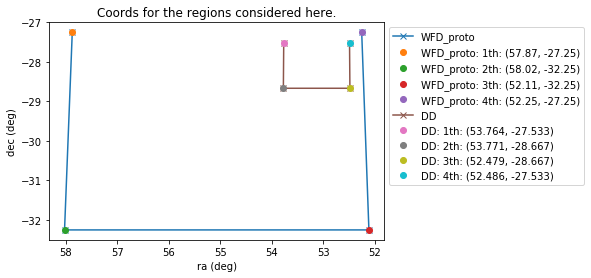


WFD_proto: xy: 
[51.447421977779562, 49.069128215264527, 44.070876788994042, 46.451145642629726] [-27.25, -32.25, -32.25, -27.25]

DD: xy: 
[47.67494409169349, 47.179891005404578, 46.046260997054674, 46.541684316580316] [-27.533, -28.667, -28.667, -27.533]


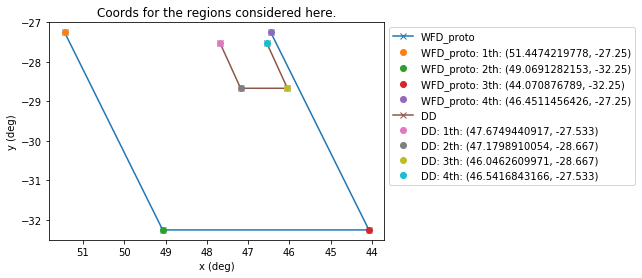

In [4]:
plot(regionCorners, xy= False, convertxy= False)
plot(regionCorners, xy= True, convertxy= True)

# WFD region corners?

In [5]:
def estRegionArea(regionCorners):
    # assumes regionCorners is a dictionary with ra, dec coords for different footprints
    for key in regionCorners.keys(): 
        ras, decs= [], []
        for ra, dec in regionCorners[key]:
            ras.append(ra)
            decs.append(dec)   
        print(key)
        print(ras, decs)
        h= decs[0]-decs[1]
        
        a= ras[0]*np.cos(np.deg2rad(decs[0]))-ras[3]*np.cos(np.deg2rad(decs[3]))
        b= ras[1]*np.cos(np.deg2rad(decs[1]))-ras[2]*np.cos(np.deg2rad(decs[2]))

        print('\x1b[1;31mdel_x_top: %s deg \ndel_x_bott: %s deg\x1b[0m'%(a, b))
        print('## area: delDec*(del_x_top+del_x_bott)/2.: \x1b[1;31m %s deg2\x1b[0m\n'%(h*(a+b)/2.))

## WFD: a square in x, y space. 


In [6]:
def findcoords_xy_sq(delx, dely, ra1= 52.25, dec1= -27.25): # start with NW corner
    print('## ra1, dec1: %.2f, %s'%(ra1, dec1))
    x1, y1= ra1*np.cos(np.deg2rad(dec1)), dec1
    print('## x1, x1: %.2f, %s\n'%(x1, y1))
    
    # add to the top edge in x
    x2, y2= x1+delx, y1
    print('## x2, x2: %.2f, %s'%(x2, y2))
    
    # calculate the update NE corner
    ra2, dec2= x2/np.cos(np.deg2rad(y2)), y2 #ra1+delra, dec1
    print('## ra2, dec2: %.2f, %s\n'%(ra2, dec2))

    # check how much is added in xy vs ra,dec
    print('x2-x1: %.2f \ny2-y1: %.2f'%(x2-x1, y2-y1))
    print('ra2-ra1: %.2f \ndec2-dec1: %.2f'%(ra2-ra1, dec2-dec1))
    
    # find the mid pt. of the top edge to drop from.
    ra_mid= (ra2+ra1)/2
    dec_new= dec1-dely
    print('ramid, dec_new: %.2f, %s'%(ra_mid, dec_new))
    
    # reset x_mid to zero; update x2,x1. rescaling needed to make sure that when
    # drop to the lower dec, follow constant x line.
    x_mid= 0.
    print('x_mid, dec_new: %.2f, %s\n'%(x_mid, dec_new))
    
    changex= (x2+x1)/2. - x_mid
    x2-=changex
    x1-=changex
    
    # now find the SE, SW corners on the re-scaled coords
    x3, y3= x_mid+delx/2, dec_new
    print('## x3, y3: %.2f, %s'%(x3, y3))

    x4, y4= x_mid-delx/2, dec_new
    print('## x4, y4: %.2f, %s'%(x4, y4))
    
    # convert to ra, dec. translate back to the region near the DDF.
    ra3, dec3= ra_mid+x3/np.cos(np.deg2rad(y3)), y3
    print('## ra3, dec3: %.2f, %s\n'%(ra3, dec3))
    
    ra4, dec4= ra_mid+x4/np.cos(np.deg2rad(y4)), y4
    print('## ra4, dec4: %.2f, %s\n'%(ra4, dec4))

    print('x3-x4: %.2f \ny3-y4: %.2f'%(x3-x4, y3-y4))
    print('ra3-ra4: %.2f \ndec3-dec4: %.2f\n'%(ra3-ra4, dec3-dec4))
    
    # order the returned lists the way they were for Run1.
    return [[ra2, dec2], [ra3, dec3], [ra4, dec4], [ra1, dec1]], [[x2, y2], [x3, y3], [x4, y4], [x1, y1]]

In [7]:
# tweaked such that area based on healpy runs is ~300deg2
delx= 17.08
dely= 17.08

In [8]:
regionCorners['WFD_Run2'], xy= findcoords_xy_sq(delx, dely)

estRegionArea(regionCorners)

## ra1, dec1: 52.25, -27.25
## x1, x1: 46.45, -27.25

## x2, x2: 63.53, -27.25
## ra2, dec2: 71.46, -27.25

x2-x1: 17.08 
y2-y1: 0.00
ra2-ra1: 19.21 
dec2-dec1: 0.00
ramid, dec_new: 61.86, -44.33
x_mid, dec_new: 0.00, -44.33

## x3, y3: 8.54, -44.33
## x4, y4: -8.54, -44.33
## ra3, dec3: 73.79, -44.33

## ra4, dec4: 49.92, -44.33

x3-x4: 17.08 
y3-y4: 0.00
ra3-ra4: 23.88 
dec3-dec4: 0.00

WFD_proto
[57.87, 58.02, 52.11, 52.25] [-27.25, -32.25, -32.25, -27.25]
del_x_top: 4.99627633515 deg 
del_x_bott: 4.99825142627 deg
## area: delDec*(del_x_top+del_x_bott)/2.:  24.9863194036 deg2

DD
[53.764, 53.771, 52.479, 52.486] [-27.533, -28.667, -28.667, -27.533]
del_x_top: 1.13325977511 deg 
del_x_bott: 1.13363000835 deg
## area: delDec*(del_x_top+del_x_bott)/2.:  1.28532650722 deg2

WFD_Run2
[71.462227979604179, 73.794710802140855, 49.917517177463317, 52.25] [-27.25, -44.33, -44.33, -27.25]
del_x_top: 17.08 deg 
del_x_bott: 17.08 deg
## area: delDec*(del_x_top+del_x_bott)/2.:  291.7264 deg2



# Comparison


WFD_proto: radec: 
[57.87, 58.02, 52.11, 52.25] [-27.25, -32.25, -32.25, -27.25]

DD: radec: 
[53.764, 53.771, 52.479, 52.486] [-27.533, -28.667, -28.667, -27.533]

WFD_Run2: radec: 
[71.462227979604179, 73.794710802140855, 49.917517177463317, 52.25] [-27.25, -44.33, -44.33, -27.25]


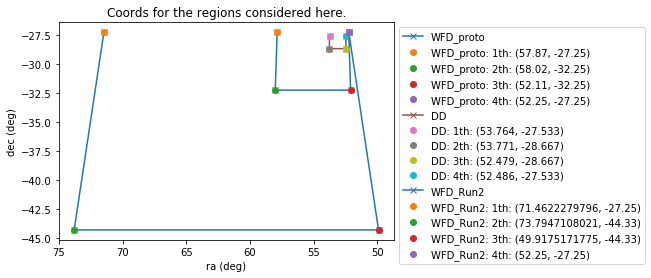


WFD_proto: xy: 
[51.447421977779562, 49.069128215264527, 44.070876788994042, 46.451145642629726] [-27.25, -32.25, -32.25, -27.25]

DD: xy: 
[47.67494409169349, 47.179891005404578, 46.046260997054674, 46.541684316580316] [-27.533, -28.667, -28.667, -27.533]

WFD_Run2: xy: 
[63.531145642629717, 52.787345125764858, 35.70734512576486, 46.451145642629726] [-27.25, -44.33, -44.33, -27.25]


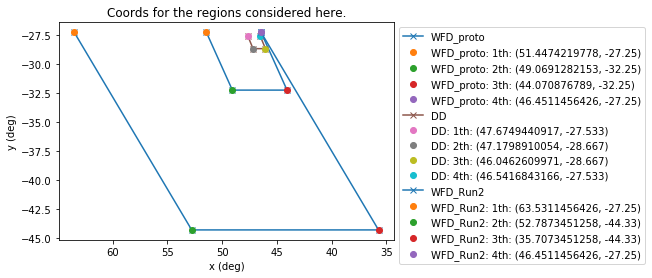

In [9]:
plot(regionCorners, xy= False, convertxy= False)
plot(regionCorners, convertxy= True)

In [10]:
estRegionArea(regionCorners)

WFD_proto
[57.87, 58.02, 52.11, 52.25] [-27.25, -32.25, -32.25, -27.25]
del_x_top: 4.99627633515 deg 
del_x_bott: 4.99825142627 deg
## area: delDec*(del_x_top+del_x_bott)/2.:  24.9863194036 deg2

DD
[53.764, 53.771, 52.479, 52.486] [-27.533, -28.667, -28.667, -27.533]
del_x_top: 1.13325977511 deg 
del_x_bott: 1.13363000835 deg
## area: delDec*(del_x_top+del_x_bott)/2.:  1.28532650722 deg2

WFD_Run2
[71.462227979604179, 73.794710802140855, 49.917517177463317, 52.25] [-27.25, -44.33, -44.33, -27.25]
del_x_top: 17.08 deg 
del_x_bott: 17.08 deg
## area: delDec*(del_x_top+del_x_bott)/2.:  291.7264 deg2




xy: radec: 
[8.5399999999999991, 8.54, -8.54, -8.5399999999999991] [-27.25, -44.33, -44.33, -27.25]


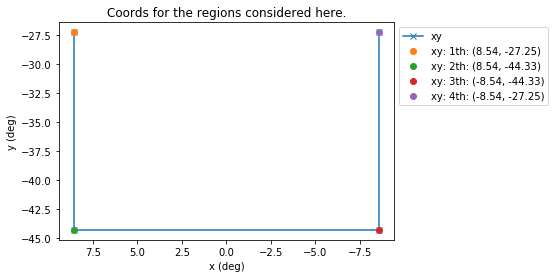

In [11]:
# check to ensure that the  region is a square in the untranslated, real degrees.
plot({'xy':xy}, xy= True, convertxy= False)

In [12]:
# [[70.8, -27.25], [72.94, -43.74], [50.11, -43.74], [52.25, -27.25]]
# hp: 279.760177083
# nonhp: 271.97747012 deg2

In [13]:
# [[71.12, -27.25],  [73.39, -44.05], [50.01, -44.05], [52.25, -27.25]]
# hp: 290.349702372
# nonhp: 282.24 deg2

In [14]:
# [[71.48, -27.25], [73.82, -44.35], [49.91, -44.35], [52.25, -27.25]]
# hp: 301.01791144
# nonhp: 292.41 deg2

#### Final resllt

In [15]:
regionCorners['WFD_Run2']

[[71.462227979604179, -27.25],
 [73.794710802140855, -44.33],
 [49.917517177463317, -44.33],
 [52.25, -27.25]]